In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
from cmap import Colormap

import numpy as np
import SimpleITK as sitk
from scipy.signal import find_peaks, peak_widths
from scipy.stats import ttest_ind
from skimage.exposure import histogram
from sklearn.linear_model import LinearRegression

from utils import *
from hu_utils import *
from hu_process import register_bspline

# Statistics

## Load data from output/

In [6]:
all_maps = np.load('..\output\DOD_KK_8530_DOD_8530_X-21-019.npz')

low_pre_maps = all_maps.f.low_pre_maps
low_post_maps = all_maps.f.low_post_maps
high_pre_maps = all_maps.f.high_pre_maps
high_post_maps = all_maps.f.high_post_maps
brown_mask_maps = all_maps.f.brown_mask_maps
white_mask_maps = all_maps.f.white_mask_maps

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\BrancaLab\AppData\Local\Temp\ipykernel_3712\1588816420.py:1: SyntaxWarning: invalid escape sequence '\o'
  all_maps = np.load('..\output\DOD_KK_8530_DOD_8530_X-21-019.npz')


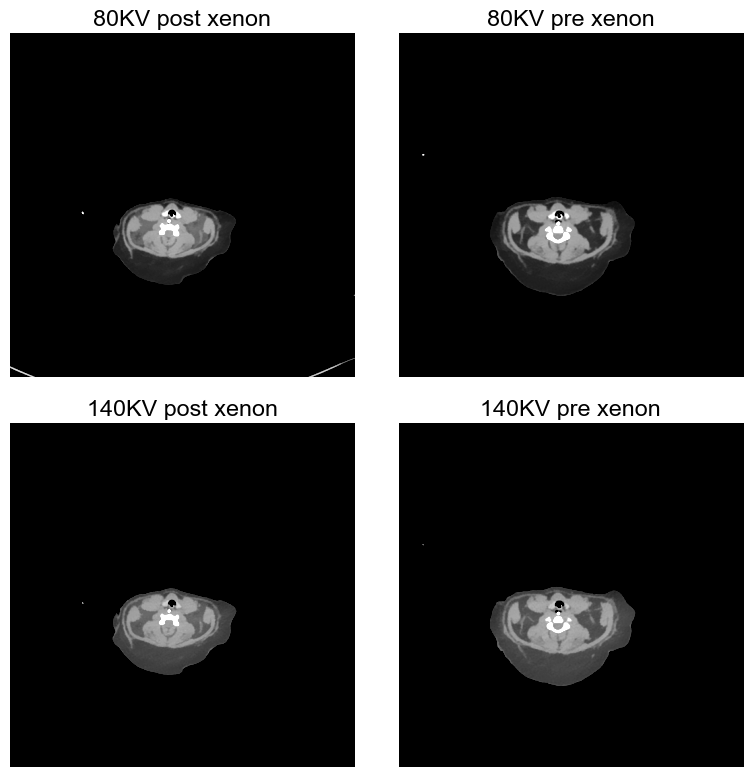

In [97]:
sample_idx = 150
sample_low_pre_map = low_pre_maps[sample_idx]
sample_low_post_map = low_post_maps[sample_idx]
sample_high_pre_map = high_pre_maps[sample_idx]
sample_high_post_map = high_post_maps[sample_idx]

# These maps are calculated from post maps
sample_brown_mask_map = brown_mask_maps[sample_idx]
sample_white_mask_map = white_mask_maps[sample_idx]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)

axes[0, 0].imshow(sample_low_post_map, cmap='gray', vmin=-200, vmax=200)
axes[0, 0].set_title('80KV post xenon')

axes[0, 1].imshow(sample_low_pre_map, cmap='gray', vmin=-200, vmax=200)
axes[0, 1].set_title('80KV pre xenon')

axes[1, 0].imshow(sample_high_post_map, cmap='gray', vmin=-200, vmax=200)
axes[1, 0].set_title('140KV post xenon')

axes[1, 1].imshow(sample_high_pre_map, cmap='gray', vmin=-200, vmax=200)
axes[1, 1].set_title('140KV pre xenon')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Histogram

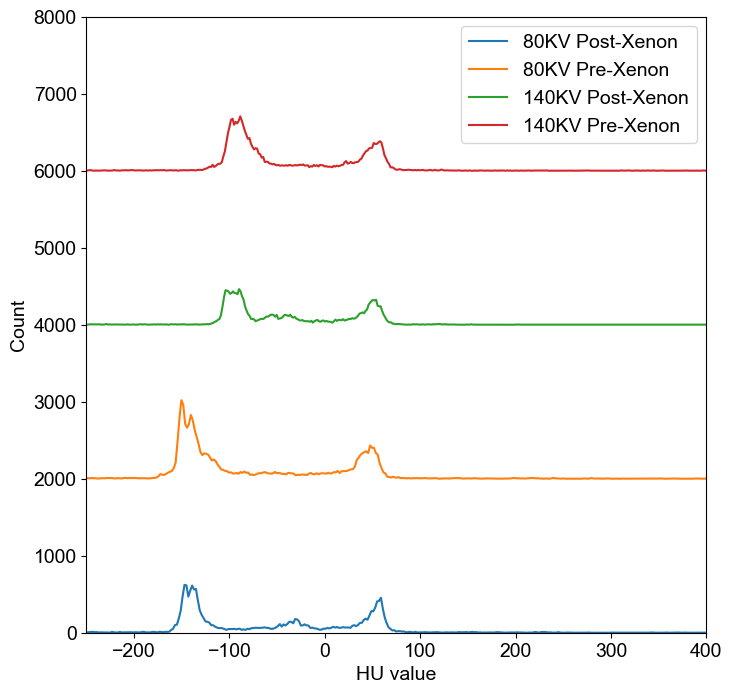

In [98]:
hist_low_post, bin_centers_low_post = histogram(sample_low_post_map, 2048)
hist_high_post, bin_centers_high_post = histogram(sample_high_post_map, 2048)
# remove the border that introduced by the registration
hist_low_pre, bin_centers_low_pre = histogram(sample_low_pre_map[sample_low_pre_map != 0], 2048)
hist_high_pre, bin_centers_high_pre = histogram(sample_high_pre_map[sample_high_pre_map != 0], 2048)

plt.figure(figsize=(8, 8))

plt.plot(bin_centers_low_post, hist_low_post, label='80KV Post-Xenon')
plt.plot(bin_centers_low_pre, hist_low_pre + 2000, label='80KV Pre-Xenon')
plt.plot(bin_centers_high_post, hist_high_post + 4000, label='140KV Post-Xenon')
plt.plot(bin_centers_high_pre, hist_high_pre + 6000, label='140KV Pre-Xenon')
plt.xlim(-250, 400)
plt.ylim(0, 8000)

plt.xlabel('HU value')
plt.ylabel('Count')
plt.legend()
plt.show()

# Image registration (optional)

In [99]:
registered_sample_high_post_map, registered_sample_high_pre_map, transform_mat = register_bspline(sample_high_post_map, sample_high_pre_map)

sample_low_post_img = sitk.GetImageFromArray(sample_low_post_map)
sample_low_pre_img = sitk.GetImageFromArray(sample_low_pre_map)
registered_sample_low_pre_img = sitk.Resample(sample_low_pre_img, sample_low_post_img, transform_mat, sitk.sitkLinear, 0.0, sample_low_pre_img.GetPixelID())
registered_sample_low_pre_map = sitk.GetArrayFromImage(registered_sample_low_pre_img)
registered_sample_low_post_map = sample_low_post_map  # no transformation to low post map

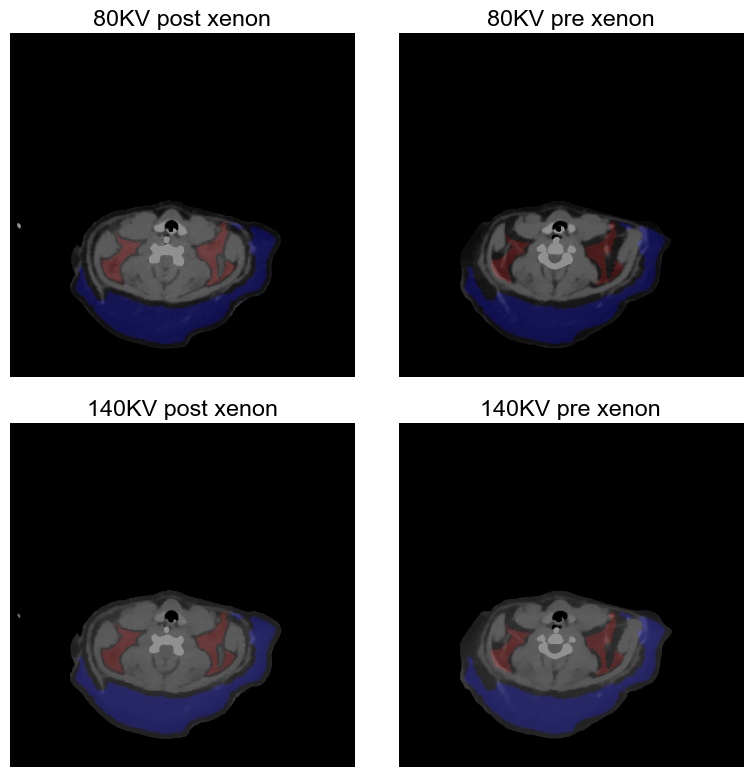

In [100]:
trim = (100, 400, 100, 400)

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)

axes[0, 0].imshow(registered_sample_low_post_map[trim[0]:trim[1], trim[2]:trim[3]], cmap='gray', vmin=-200, vmax=200)
axes[0, 0].imshow(sample_brown_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:red').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[0, 0].imshow(sample_white_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:blue').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[0, 0].set_title('80KV post xenon')

axes[0, 1].imshow(registered_sample_low_pre_map[trim[0]:trim[1], trim[2]:trim[3]], cmap='gray', vmin=-200, vmax=200)
axes[0, 1].imshow(sample_brown_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:red').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[0, 1].imshow(sample_white_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:blue').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[0, 1].set_title('80KV pre xenon')

axes[1, 0].imshow(registered_sample_high_post_map[trim[0]:trim[1], trim[2]:trim[3]], cmap='gray', vmin=-200, vmax=200)
axes[1, 0].imshow(sample_brown_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:red').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[1, 0].imshow(sample_white_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:blue').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[1, 0].set_title('140KV post xenon')

axes[1, 1].imshow(registered_sample_high_pre_map[trim[0]:trim[1], trim[2]:trim[3]], cmap='gray', vmin=-200, vmax=200)
axes[1, 1].imshow(sample_brown_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:red').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[1, 1].imshow(sample_white_mask_map[trim[0]:trim[1], trim[2]:trim[3]], cmap=Colormap('cmap:blue').to_mpl(), vmin=0, vmax=1, alpha=0.25)
axes[1, 1].set_title('140KV pre xenon')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

## pixel value statistics

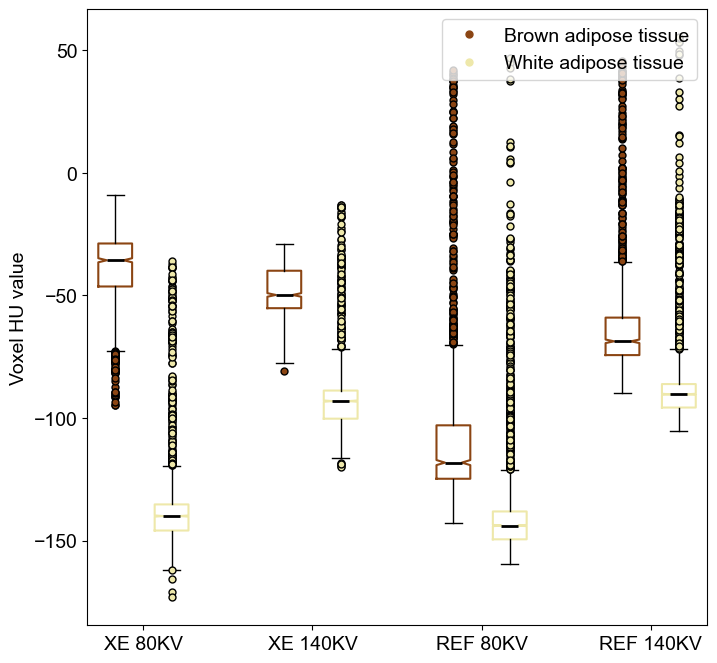

In [101]:
white_size = len(registered_sample_low_post_map[sample_white_mask_map])
brown_size = len(registered_sample_low_post_map[sample_brown_mask_map])

data = np.vstack((np.pad(registered_sample_low_post_map[sample_brown_mask_map], (0, white_size - brown_size), constant_values=np.nan),
                  registered_sample_low_post_map[sample_white_mask_map],
                  np.pad(registered_sample_high_post_map[sample_brown_mask_map], (0, white_size - brown_size), constant_values=np.nan),
                  registered_sample_high_post_map[sample_white_mask_map],
                  np.pad(registered_sample_low_pre_map[sample_brown_mask_map], (0, white_size - brown_size), constant_values=np.nan),
                  registered_sample_low_pre_map[sample_white_mask_map],
                  np.pad(registered_sample_high_pre_map[sample_brown_mask_map], (0, white_size - brown_size), constant_values=np.nan),
                  registered_sample_high_pre_map[sample_white_mask_map])).T

data = np.ma.masked_invalid(data)

plt.figure(figsize=(8, 8))

positions = []
for i in range(4):
    positions.append(i * 3 + 1)
    positions.append(i * 3 + 2)

boxprops_brown = dict(linestyle='-', linewidth=1.5, color='saddlebrown')
boxprops_yellow = dict(linestyle='-', linewidth=1.5, color='palegoldenrod')
medianprops = dict(linestyle='-', linewidth=2, color='black')
flierprops_brown = dict(marker='o', markerfacecolor='saddlebrown', markersize=5, linestyle='none')
flierprops_yellow = dict(marker='o', markerfacecolor='palegoldenrod', markersize=5, linestyle='none')

# Creating the box plots
for i in range(8):
    boxprops = boxprops_brown if i % 2 == 0 else boxprops_yellow
    flierprops = flierprops_brown if i % 2 == 0 else flierprops_yellow
    plt.boxplot(data[:, i].compressed(), positions=[positions[i]], patch_artist=False, notch=True, vert=1, widths=0.6, 
                boxprops=boxprops, medianprops=medianprops, flierprops=flierprops)
plt.xticks([1.5, 4.5, 7.5, 10.5], ['XE 80KV', 'XE 140KV', 'REF 80KV', 'REF 140KV'])
plt.ylabel('Voxel HU value')

# Adding legend
brown_patch = plt.Line2D([], [], color='saddlebrown', marker='o', linestyle='None', markersize=5, label='Brown adipose tissue')
yellow_patch = plt.Line2D([], [], color='palegoldenrod', marker='o', linestyle='None', markersize=5, label='White adipose tissue')
plt.legend(handles=[brown_patch, yellow_patch], loc='upper right')

plt.show()

# Material decomposition

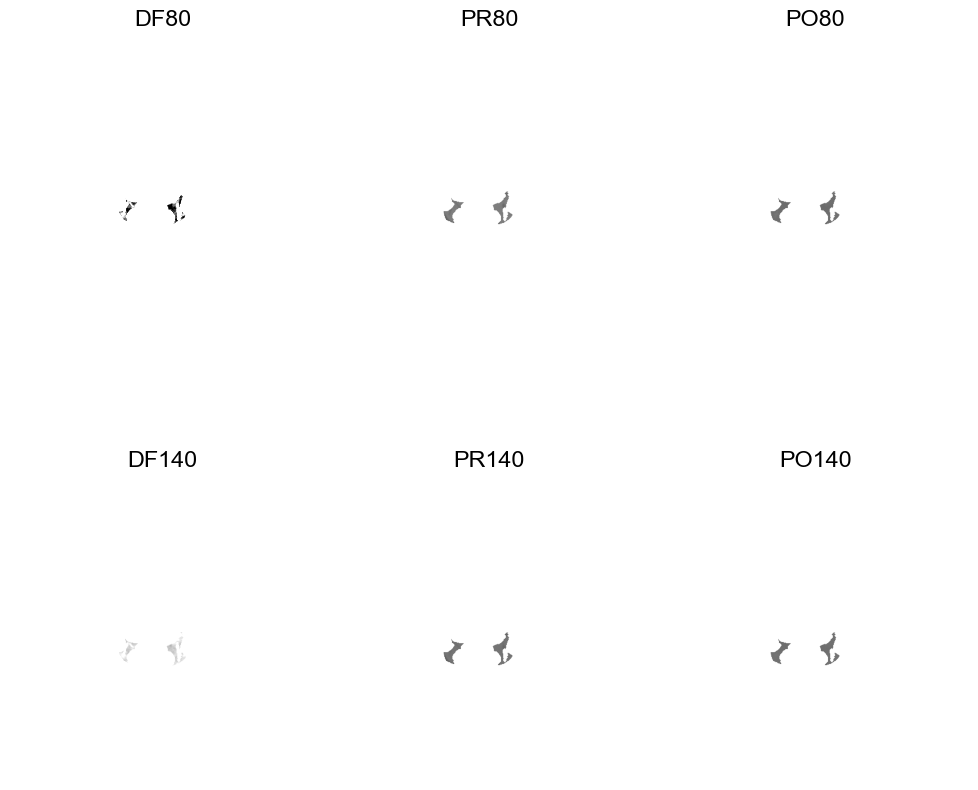

In [120]:
DF80_2D = np.where(sample_brown_mask_map, registered_sample_low_post_map - registered_sample_low_pre_map, 0)
PR80_2D = np.where(sample_brown_mask_map, registered_sample_low_pre_map + 1000, 0)
PO80_2D = np.where(sample_brown_mask_map, registered_sample_low_post_map + 1000, 0)
DF80 = DF80_2D.reshape(-1, 1)
PR80 = PR80_2D.reshape(-1, 1)
PO80 = PO80_2D.reshape(-1, 1)
DF80 = DF80[DF80 != 0][:, np.newaxis]
PR80 = PR80[PR80 != 0][:, np.newaxis]
PO80 = PO80[PO80 != 0][:, np.newaxis]

DF140_2D = np.where(sample_brown_mask_map, registered_sample_high_post_map - registered_sample_high_pre_map, 0)
PR140_2D = np.where(sample_brown_mask_map, registered_sample_high_pre_map + 1000, 0)
PO140_2D = np.where(sample_brown_mask_map, registered_sample_high_post_map + 1000, 0)
DF140 = DF140_2D.reshape(-1, 1)
PR140 = PR140_2D.reshape(-1, 1)
PO140 = PO140_2D.reshape(-1, 1)
DF140 = DF140[DF140 != 0][:, np.newaxis]
PR140 = PR140[PR140 != 0][:, np.newaxis]
PO140 = PO140[PO140 != 0][:, np.newaxis]

plt.figure(figsize=(10, 10))

plt.subplot(231)
plt.imshow(DF80_2D, cmap='Grays', vmin=50, vmax=100)
plt.title('DF80')
plt.axis('off')

plt.subplot(232)
plt.imshow(PR80_2D, cmap='Grays', vmin=0, vmax=1500)
plt.title('PR80')
plt.axis('off')

plt.subplot(233)
plt.imshow(PO80_2D, cmap='Grays', vmin=0, vmax=1500)
plt.title('PO80')
plt.axis('off')

plt.subplot(234)
plt.imshow(DF140_2D, cmap='Grays', vmin=0, vmax=100)
plt.title('DF140')
plt.axis('off')

plt.subplot(235)
plt.imshow(PR140_2D, cmap='Grays', vmin=0, vmax=1500)
plt.title('PR140')
plt.axis('off')

plt.subplot(236)
plt.imshow(PO140_2D, cmap='Grays', vmin=0, vmax=1500)
plt.title('PO140')
plt.axis('off')

plt.tight_layout()
plt.show()

In [121]:
reg_df = LinearRegression(fit_intercept=True).fit(DF80, DF140)
slope_df = reg_df.coef_.item()
intercept_df = reg_df.intercept_.item()
print(reg_df.score(DF80, DF140))

reg_pr = LinearRegression(fit_intercept=True).fit(PR80, PR140)
slope_pr = reg_pr.coef_.item()
intercept_pr = reg_pr.intercept_.item()
print(reg_pr.score(PR80, PR140))

0.9166644554315962
0.9485376271666199


Text(0, 0.5, 'DF(140)')

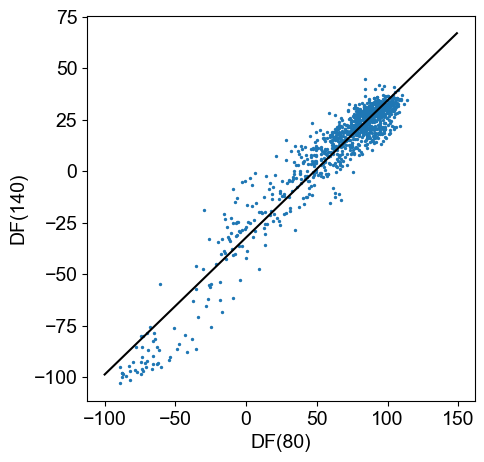

In [122]:
plt.figure(figsize=(5, 5))
plt.scatter(DF80, DF140, s=2)

reg_x_df = np.arange(-100, 150, 1)
reg_y_df = slope_df * reg_x_df + intercept_df
plt.plot(reg_x_df, reg_y_df, 'k')
plt.xlabel('DF(80)')
plt.ylabel('DF(140)')

# plt.xlim(-100, 150)
# plt.ylim(-100, 150)

Text(0, 0.5, 'PR(140)')

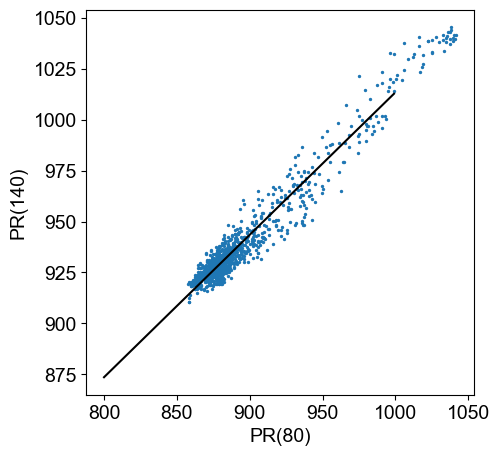

In [123]:
plt.figure(figsize=(5, 5))
plt.scatter(PR80, PR140, s=2)

reg_x_pr = np.arange(800, 1000, 1)

reg_y_pr = slope_pr * reg_x_pr + intercept_pr
plt.plot(reg_x_pr, reg_y_pr, 'k')

# plt.xlim(800, 1000)
# plt.ylim(850, 1100)

plt.xlabel('PR(80)')
plt.ylabel('PR(140)')

In [124]:
sf = slope_pr
sx = slope_df
cf = intercept_pr
cx = intercept_df


hu_f_80 = np.mean(PR80)
hu_f_140 = (hu_f_80) * sf + cf
hu_x_80 = np.mean(DF80)
hu_x_140 = (hu_x_80) * sx + cx

print(hu_f_140)

940.0758124581218


In [125]:
cf

314.2152686001208

In [126]:
A = np.array([[hu_f_80, hu_x_80],
              [hu_f_140, hu_x_140]])
print(A)
AINV = np.linalg.inv(A)
print(AINV)

[[895.08050854  65.66911164]
 [940.07581246  11.48635847]]
[[-0.00022324  0.0012763 ]
 [ 0.01827067 -0.01739617]]


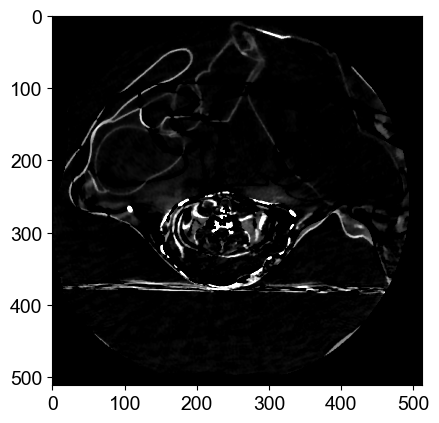

In [127]:
plt.imshow(registered_sample_high_post_map - registered_sample_high_pre_map, cmap='gray', vmin=0, vmax=100)

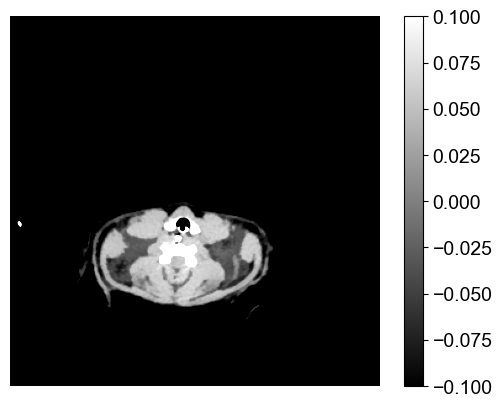

In [131]:
sample_flat = np.vstack((sample_low_post_map.reshape(1, -1), sample_low_post_map.reshape(1, -1)))
decomp_flat = np.matmul(AINV, sample_flat)
material1 = decomp_flat[0].reshape(sample_low_post_map.shape)
material2 = decomp_flat[1].reshape(sample_low_post_map.shape)

sample_brown_mask = sample_brown_mask_map
sample_white_mask = sample_white_mask_map

# plt.imshow(np.where(np.logical_or(sample_brown_mask, sample_white_mask), material1, np.nan), cmap='gray', vmin=-1, vmax=1)
plt.imshow(material1[trim[0]:trim[1], trim[2]:trim[3]], cmap='gray', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.axis('off')
plt.show()